In [260]:
import csv
import re

In [11]:
#http://files.grouplens.org/datasets/movielens/ml-100k.zip
! ls data/ml-100k

README       u.genre      u.user       u2.test      u4.test      ua.test
allbut.pl    u.info       u1.base      u3.base      u5.base      ub.base
mku.sh       u.item       u1.test      u3.test      u5.test      ub.test
u.data       u.occupation u2.base      u4.base      ua.base


In [261]:
MOVIES = "data/ml-100k/u.item"
RATINGS = "data/ml-100k/u.data"

In [262]:
with open(MOVIES, encoding='iso-8859-1') as f:
    reader = csv.reader(f, delimiter='|')
    movies = {movie_id: title for movie_id, title, *_ in reader}

In [263]:
with open(RATINGS, encoding='iso-8859-1') as f:
    reader = csv.reader(f, delimiter='\t')
    ratings = [(user_id, movie_id, float(rating)) for user_id, movie_id, rating, _ in reader]

## Star Wars only

In [25]:
swars = {movie_id:[] for movie_id, title in movies.items() if re.search("Star Wars|Empire Strikes|Jedi", title)}

In [27]:
for (user_id, movie_id, rating) in ratings:
    if movie_id in swars:
        swars[movie_id].append(rating)

In [37]:
for movie_id, rats in swars.items():
    avg = sum(rats)/len(rats)
    print(f"{movies[movie_id]}  {avg:.2f}")

Star Wars (1977)  4.36
Empire Strikes Back, The (1980)  4.20
Return of the Jedi (1983)  4.01


## Factors

In [46]:
import random
import math

def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0):
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]

def inverse_normal_cdf(p: float,
                       mu: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Find approximate inverse using binary search"""

    # if not standard, compute standard and rescale
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) is (very close to) 0
    hi_z  =  10.0                      # normal_cdf(10)  is (very close to) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Consider the midpoint
        mid_p = normal_cdf(mid_z)      # and the cdf's value there
        if mid_p < p:
            low_z = mid_z              # Midpoint too low, search above it
        else:
            hi_z = mid_z               # Midpoint too high, search below it

    return mid_z

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

In [48]:
import tqdm

In [264]:
rrs = 0
DIMS = 2

user_vectors = {user_id: random_normal(DIMS) for user_id,*_ in ratings}
movie_vectors = {movie_id: random_normal(DIMS) for user_id, movie_id,_ in ratings}

In [259]:

def loop(data, learning_rate):
    with tqdm.tqdm(data) as t:
        loss = 0.0
        for i, (user_id, movie_id, rating) in enumerate(t):
            movie_vec = movie_vectors[movie_id]
            user_vec = user_vectors[user_id]
            # dot:
            predicted = sum(v_i * w_i for v_i, w_i in zip(user_vec, movie_vec))
            error = predicted - rating
            loss += error **2

            if learning_rate is not None:
                user_gradient = [error * m_j for m_j in movie_vec]
                movie_gradient = [error * u_j for u_j in user_vec]

                for j in range(DIMS):
                    user_vec[j] -= learning_rate*user_gradient[j]
                    movie_vec[j] -= learning_rate*movie_gradient[j]

            t.set_description(f"loss: {loss/(i+1)}")

In [265]:
loop(ratings, learning_rate=0.05)

loss: 3.3831089021777303: 100%|██████████| 100000/100000 [02:14<00:00, 743.24it/s]


In [267]:
learning_rate = 0.05 * 0.9
for epoch in range(10):
    learning_rate *=0.9
    print(epoch, learning_rate)
    loop(ratings, learning_rate=learning_rate)

loss: 1.1634503279451716:   0%|          | 21/100000 [00:00<08:32, 195.12it/s]

0 0.04050000000000001


loss: 0.9685112145315291:   0%|          | 126/100000 [00:00<01:19, 1252.82it/s]

2 0.03280500000000001


loss: 0.9981097461252327:   0%|          | 67/100000 [00:00<03:57, 420.47it/s]

3 0.02952450000000001


loss: 0.9547682430569346:   0%|          | 0/100000 [00:00<?, ?it/s]  

4 0.02657205000000001


loss: 0.9321777015575355:   0%|          | 114/100000 [00:00<01:28, 1127.71it/s]

5 0.02391484500000001


loss: 0.8871217323532106:   0%|          | 96/100000 [00:00<01:44, 959.24it/s]

6 0.021523360500000012


loss: 0.935762265801052:   0%|          | 108/100000 [00:00<01:33, 1073.47it/s] 

7 0.01937102445000001


loss: 0.8360206107734359:   0%|          | 101/100000 [00:00<01:39, 1003.52it/s]

9 0.015690529804500006


loss: 0.8344517784862926: 100%|██████████| 100000/100000 [02:39<00:00, 627.95it/s]


In [268]:
from collections import defaultdict

ratings_by_movie = defaultdict(list)

for (uid, movie_id, rating) in ratings:
    ratings_by_movie[movie_id].append(rating)
    
avg_rat = {movie_id: sum(ras)/len(ras) for movie_id, ras in ratings_by_movie.items()}

In [111]:
tops = sorted(avg_rat.items(), key=lambda a: a[1], reverse=True)[:25]

topv = {movie_id: [movie_vectors[movie_id][0], movie_vectors[movie_id][1], rat] for movie_id, rat in tops}

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
df = pd.DataFrame.from_dict(topv, orient='index', columns=['x', 'y', 'rat'])

In [219]:
# %load ../retina.py
%config InlineBackend.figure_format = 'retina'


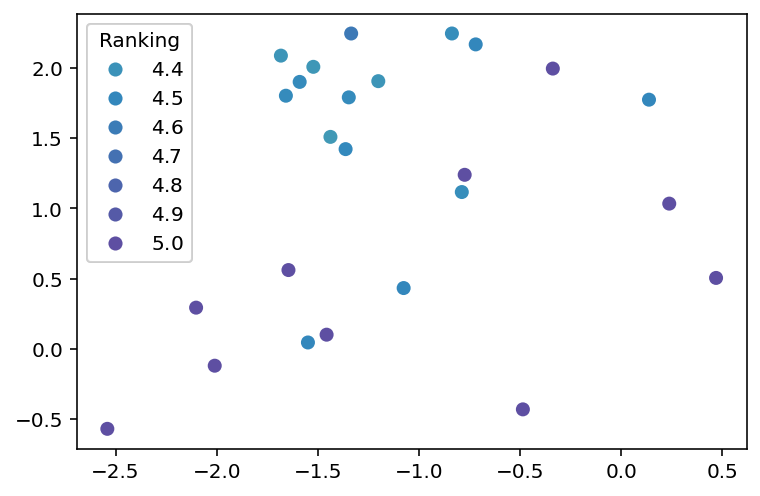

In [134]:
fig, ax = plt.subplots()

# Because the price is much too small when being provided as size for ``s``,
# we normalize it to some useful point sizes, s=0.3*(price*3)**2
scatter = ax.scatter(df.x, df.y, c=df.rat, vmin=0, vmax=5, cmap="Spectral")
legend1 = ax.legend(*scatter.legend_elements(num=8),loc="upper left", title="Ranking")
ax.add_artist(legend1)


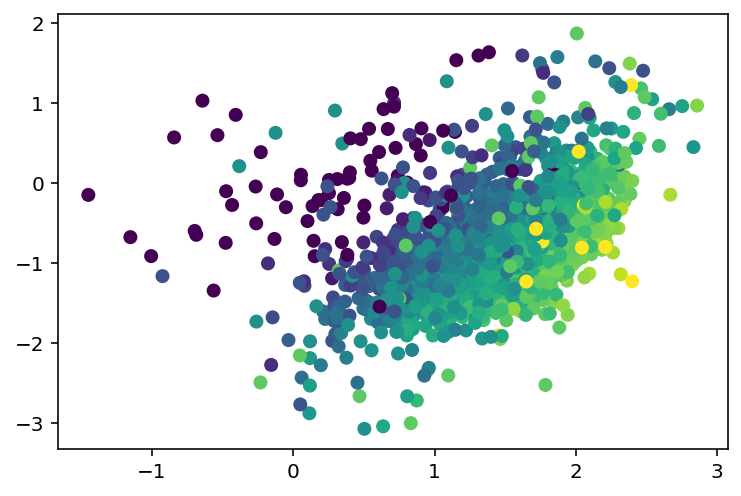

In [280]:
alls = {movie_id: [movie_vectors[movie_id][0], movie_vectors[movie_id][1], rat] for movie_id, rat in avg_rat.items()}
alf = pd.DataFrame.from_dict(alls, orient='index', columns=['em1', 'em2', 'rat'])

plt.scatter(alf.em1, alf.em2, c=alf.rat)
plt.colorbar()

## maybe better with PCA

In [138]:
from sklearn.decomposition import PCA

In [269]:
alls = {movie_id: [movie_vectors[movie_id][0], movie_vectors[movie_id][1], rat] for movie_id, rat in avg_rat.items()}
alf = pd.DataFrame.from_dict(alls, orient='index', columns=['em1', 'em2', 'rat'])

In [270]:
alf['movie_id'] = alf.index
alf['r1'] = range(len(alf))
alf.set_index(alf.r1, inplace=True)
alf.drop(labels=['r1'], axis=1, inplace=True)

In [271]:
pca = PCA(n_components=2)
pca.fit(alf[['em1', 'em2']])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [272]:
pcas = pd.DataFrame(pca.transform(alf[['em1', 'em2']]), columns=['p1', 'p2'])

In [273]:
als = alf.join(pcas)

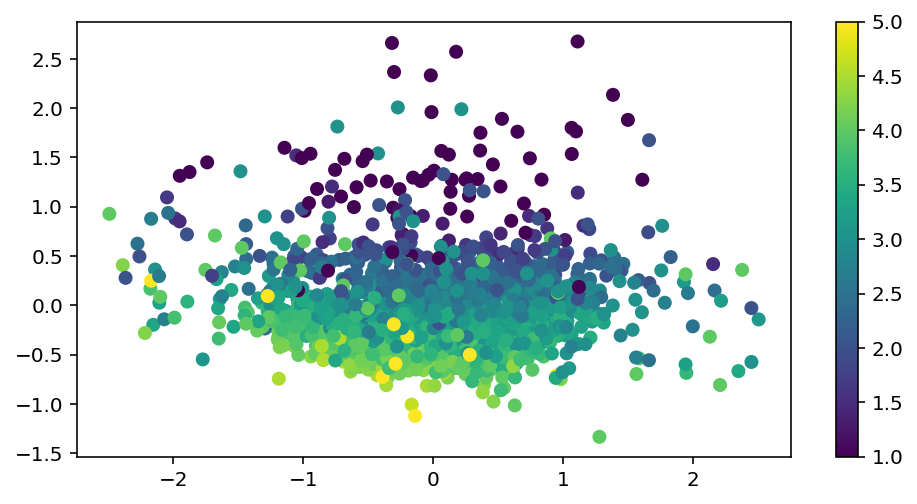

In [277]:
plt.figure(figsize=(8, 4))
plt.scatter(als.p1, als.p2, c=als.rat)
plt.colorbar();

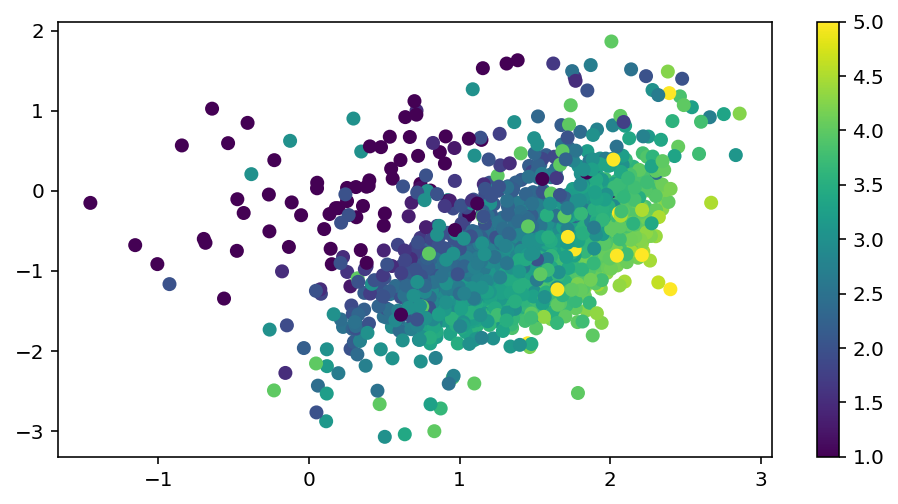

In [275]:
plt.figure(figsize=(8, 4))
plt.scatter(als.em1, als.em2, c=als.rat)
plt.colorbar();